In [142]:
import numpy as np 
import pandas as pd 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Input, Dropout,BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [114]:
df = pd.read_csv(r'datasets/train.csv')
df.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [115]:
df['cb_person_default_on_file'].unique()

array(['N', 'Y'], dtype=object)

In [116]:
df.drop(columns = ['loan_intent','loan_grade'],inplace = True)

In [117]:
df.isnull().sum()

id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

In [118]:
df["cb_person_default_on_file"] = LabelEncoder().fit_transform(df["cb_person_default_on_file"])
df = pd.get_dummies(df, columns=["person_home_ownership"], drop_first=True)

In [119]:
df.head()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT
0,0,37,35000,0.0,6000,11.49,0.17,0,14,0,False,False,True
1,1,22,56000,6.0,4000,13.35,0.07,0,2,0,False,True,False
2,2,29,28800,8.0,6000,8.90,0.21,0,10,0,False,True,False
3,3,30,70000,14.0,12000,11.11,0.17,0,5,0,False,False,True
4,4,22,60000,2.0,6000,6.92,0.10,0,3,0,False,False,True


In [120]:
#moving target column to last
status_id = df.pop('loan_status')  # Remove the PassengerId column
df.insert(df.columns.get_loc('person_home_ownership_RENT') + 1, 'loan_status', status_id)  # Insert after person_home_ownership_RENT

In [121]:
df.head()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,loan_status
0,0,37,35000,0.0,6000,11.49,0.17,0,14,False,False,True,0
1,1,22,56000,6.0,4000,13.35,0.07,0,2,False,True,False,0
2,2,29,28800,8.0,6000,8.90,0.21,0,10,False,True,False,0
3,3,30,70000,14.0,12000,11.11,0.17,0,5,False,False,True,0
4,4,22,60000,2.0,6000,6.92,0.10,0,3,False,False,True,0


In [122]:
df.dtypes

id                               int64
person_age                       int64
person_income                    int64
person_emp_length              float64
loan_amnt                        int64
loan_int_rate                  float64
loan_percent_income            float64
cb_person_default_on_file        int32
cb_person_cred_hist_length       int64
person_home_ownership_OTHER       bool
person_home_ownership_OWN         bool
person_home_ownership_RENT        bool
loan_status                      int64
dtype: object

In [123]:
y = df.iloc[:,-1]

In [124]:
X = df.iloc[:,:-1]

In [125]:
train_X,test_X,train_y,test_y = train_test_split(X,y,test_size=0.2,random_state=15)

In [126]:
scaler = StandardScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

In [127]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [128]:
model = Sequential([
    Input(shape=(train_X.shape[1],)),  
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),  # Normalize layer activations
    Dropout(0.3),  
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),  
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  
])

In [129]:
optimizer = Adam(learning_rate=0.0005)  # Reduce learning rate
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [130]:
training = model.fit(train_X,train_y,epochs = 10, validation_data=(test_X,test_y))

Epoch 1/10
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7677 - loss: 0.9905 - val_accuracy: 0.9031 - val_loss: 0.4434
Epoch 2/10
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8936 - loss: 0.4294 - val_accuracy: 0.9065 - val_loss: 0.3186
Epoch 3/10
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8964 - loss: 0.3255 - val_accuracy: 0.9130 - val_loss: 0.2739
Epoch 4/10
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9048 - loss: 0.2815 - val_accuracy: 0.9135 - val_loss: 0.2549
Epoch 5/10
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9097 - loss: 0.2653 - val_accuracy: 0.9165 - val_loss: 0.2437
Epoch 6/10
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9137 - loss: 0.2487 - val_accuracy: 0.9169 - val_loss: 0.2437
Epoch 7/10
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9135 - loss: 0.2499 - val_accuracy: 0.9154 - val_loss: 0.2413
Epoch 8/10
1467/1467 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9121 - loss: 0.2503 - 

In [131]:
pred_y_prob = model.predict(test_X)
pred_y = (pred_y_prob > 0.5).astype(int)

367/367 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step 


In [132]:
accuracy = accuracy_score(test_y, pred_y)
print(f"Model Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_report(test_y, pred_y))

Model Accuracy: 0.92
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.98      0.95      9999
           1       0.84      0.54      0.66      1730

    accuracy                           0.92     11729
   macro avg       0.88      0.76      0.81     11729
weighted avg       0.91      0.92      0.91     11729



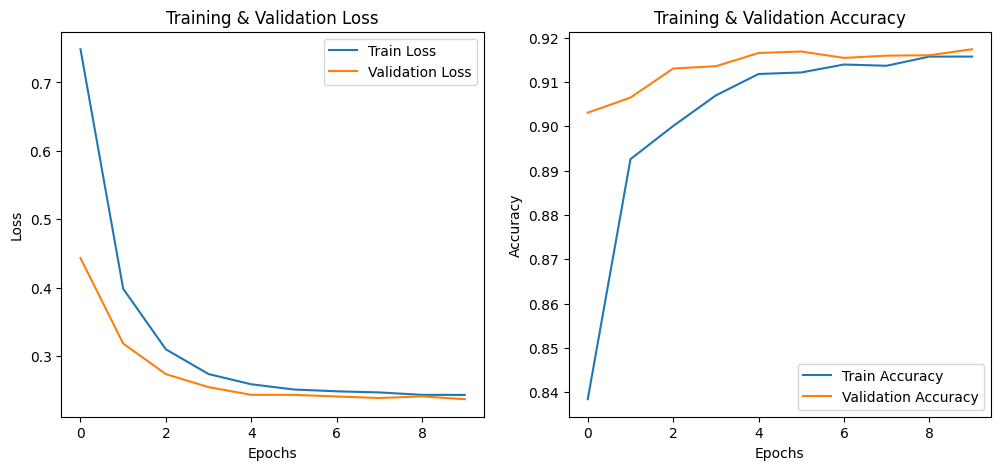

In [133]:
# Plot Training & Validation Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(training.history['loss'], label='Train Loss')
plt.plot(training.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Plot Training & Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(training.history['accuracy'], label='Train Accuracy')
plt.plot(training.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()

In [111]:
testing = pd.read_csv(r'datasets/test.csv')

In [136]:
testing.head()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT
0,58645,23,69000,3.0,25000,15.76,0.36,0,2,False,False,True
1,58646,26,96000,6.0,10000,12.68,0.10,1,4,False,False,False
2,58647,26,30000,5.0,4000,17.19,0.13,1,2,False,False,True
3,58648,33,50000,4.0,7000,8.90,0.14,0,7,False,False,True
4,58649,26,102000,8.0,15000,16.32,0.15,1,4,False,False,False


In [134]:
testing.drop(columns = ['loan_intent','loan_grade'],inplace = True)

In [135]:
testing["cb_person_default_on_file"] = LabelEncoder().fit_transform(testing["cb_person_default_on_file"])
testing = pd.get_dummies(testing, columns=["person_home_ownership"], drop_first=True)

In [137]:
scaler = StandardScaler()
new_data_scaled = scaler.fit_transform(testing)

In [138]:
y_pred_prob = model.predict(new_data_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

1222/1222 ━━━━━━━━━━━━━━━━━━━━ 1s 862us/step


In [141]:
output_df = pd.DataFrame({"id": testing["id"], "loan_status": y_pred.flatten()})
output_df.to_csv("predicted_loans.csv", index=False)
print("Predictions saved to predicted_loans.csv")

Predictions saved to predicted_loans.csv
